# 동영상에서 배경음악 분리

- 참고 : https://dacon.io/competitions/official/235905/codeshare/5138

### 분석환경 준비

In [ ]:
# !pip install -r requiremets.txt

In [28]:
import librosa
import librosa.display as dsp
from IPython.display import Audio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### 1. 동영상에서 오디오 추출

##### **moviepy 라이브러리**
- 참고: https://chacha95.github.io/2019-10-24-Movipy/
<br>

- python을 이용한 Video Processing에 최적화된 library
- 비디오 및 오디오의 합성이나 애니메이션, GIF 파일 생성 등 가능
- ffmpeg를 이용해 비디오와 오디오를 읽고, 씀
- 읽어들인 정보들은 numpy, scipy와 같은 라이브러리를 이용해 편집이 가능함.
<br><br>
- **어떤 경우에 써야 하나요?**
    - 여러 비디오에 대해 처리할 때
    - 여러 비디오를 복잡한 방식으로 합칠 때
    - video effect를 추가하고 싶을 때(다른 video editor 없이)
    - 여러 이미지를 이용해 GIF를 만들고 싶을 때
<br><br>
- **어떤 경우에 쓰면 안되나요?**
    - frame-by-frame의 비디오 분석에 사용할 때 -> OpenCV와 같은 좋은 library가 있음
    - 단순히 비디오 파일을 이미지로 쪼개고 싶을 때 -> OpenCV와 같은 좋은 library가 존재
    - stream video에 대한 작업엔 적합하지 않음
    - 비디오의 개수가 많을 경우(100개 이상) 적합하지 않음
<br><br>
- **MoviePy 특징**
    - 간단하며 직관적임
    - Flexible함
    - Protable함
    - numpy와의 호환성

- **주요 기능**
    - 기본 단위는 clips로 불리며, 크게 AudioClips, VideoClips, AudioFileClip, VideoFileClip 클래스로 구성됨.
    - 하지만 AudioFileclip과 VideoFileClip이 주로 사용
<br><br>

- **AudioFileclip**
    - audio file이나 video file에서 오디오를 추출하는 기능을 하는 class임.
<br><br>

- **VideoFileClip**
    - VideoClips class 보다 user-friendly한 클래스이며, 대부분의 예제코드가 VideoFileClip class를 이용함

In [29]:
# 모듈 로딩
import moviepy.editor as mp

In [31]:
# 오디오 추출

data_path = 'data/'
clip = mp.VideoFileClip(data_path + "video_furious.mp4")
clip.audio.write_audiofile(data_path + "audio_furious.mp3")

MoviePy - Writing audio in data/audio_furious.mp3


MoviePy - Done.


##### 오디오 시각화

##### **librosa 라이브러리**

- 참고: https://wikidocs.net/192879
- 음악 및 오디오 신호 처리를 위한 파이썬 라이브러리
- 음악 분석, 오디오 신호 변환 및 기타 오디오 처리 작업을 수행하기 위한 다양한 기능을 제공
<br>

- **주요기능**
    - 오디오 파일을 로드하고 저장하기 위한 함수
    - 음악의 스펙트로그램, 멜 스펙트로그램 및 스펙트럼을 생성하는 함수
    - 음악의 템포, 비트, 리듬 및 주파수를 추출하는 함수
    - 음악 신호를 필터링하고 변환하는 함수
    - 음악 데이터를 시각화하는 함수


In [35]:
# # 여러개의 오디오를 한 번에 시각화
# def get_audio(num = 0):
#     # # Audio Sample Directory
#     # sample = os.listdir('data/train')
#     # temp = train[train.label == num].file_name
#     # file_name = temp[temp.index[0]]
    
#     # file = 'data/train/' + file_name
#     # Get Audio from the location
#     # data,sample_rate = librosa.load(file)
#     data,sample_rate = librosa.load(data_path + 'audio_furious.mp3')

#     # Plot the audio wave
#     plt.figure(figsize=(20, 5))
#     dsp.waveshow(data,sr=sample_rate)
#     plt.show()
    
#     # Show the widget
#     return Audio(data=data,rate=sample_rate)

In [36]:
# get_audio(num = 0)

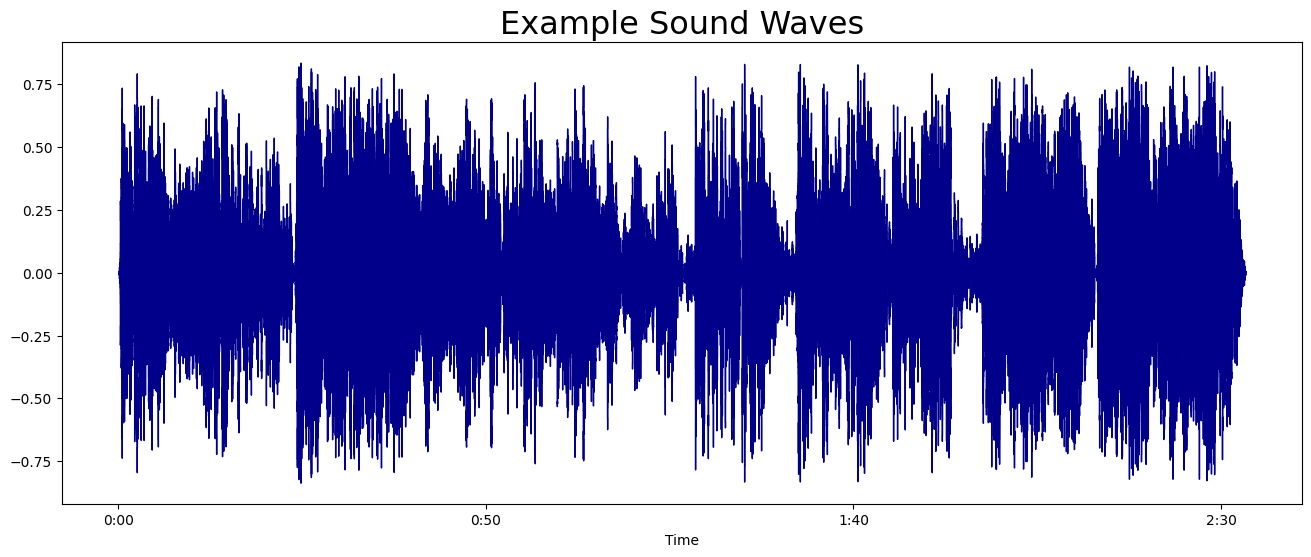

In [34]:
data,sample_rate = librosa.load(data_path + 'audio_furious.mp3')

audio, _ = librosa.effects.trim(data)

plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio, sr = sample_rate, color = "#00008B")
plt.title("Example Sound Waves", fontsize = 23)
Audio(data=data,rate=sample_rate)

### 2. 오디오에서 대사와 배경음 분리

> 오디오에는 대사뿐만 아니라 배경음악, 효과음, 사물 등의 소리가 포함됨  
  -> 여기에서 오직 배경음악만을 분리할 것인지? 분리한다면, 어떤 방법을 사용할 것인지?

### **Wave-U-Net**

- 이미지 segmentation에서 널리 쓰이는 U-Net을 파형 입력에 적용한 기법인 Wave-U-Net을 활용해 대사와 배경음악을 분리한다. 
- Wave-U-Net은 오디오 신호를 시간 축으로 분석하여 각 소스가 언제 발생하는지에 따라 분리함으로써 오디오 신호의 특징을 파악한다. 
- 장기적인 시간 간의 상관관계를 파악하여 큰 문맥을 고려할 수 있으며, 특징 맵을 반복적으로 리샘플링하여 다양한 시간 스케일에서 특징을 계산하고 결합한다. 
- 따라서, 오디오 신호에서 발생하는 다양한 시간적 구조를 파악하고, 이를 활용하여 각 소스를 정확하게 분리할 수 있다


코드
- 텐서플로우 버전: https://github.com/f90/Wave-U-Net  
- 파이토치 버전(improved): https://github.com/f90/Wave-U-Net-Pytorch
<br>
<br>
<br>
Wave-U-Net은 오디오 소스 분리를 위한 딥러닝 모델로, 실제로 사용하려면 다음과 같은 단계를 거쳐야 함.

1. **데이터 수집**: Wave-U-Net 모델을 학습시키기 위해서는 오디오 신호의 입력과 각 소스의 출력이 필요함. 이러한 데이터는 실제 음악 또는 음성 신호에서 추출할 수 있음.

2. **데이터 전처리**: Wave-U-Net 모델에 입력하기 전에, 데이터를 전처리하여 적절한 형식으로 변환해야 함. 이 과정에서는 오디오 신호를 일정한 길이로 자르고, 주파수 스펙트럼 등의 특징을 추출할 수 있음.

3. **모델 학습**: 전처리된 데이터를 사용하여 Wave-U-Net 모델을 학습시킴. 이 과정에서는 입력 오디오 신호와 각 소스의 출력 사이의 관계를 파악하도록 모델을 조정함.

4. **모델 평가**: 학습된 Wave-U-Net 모델을 사용하여 새로운 입력 오디오 신호에 대해 각 소스를 분리함. 이 과정에서는 분리된 각 소스가 원본과 얼마나 유사한지 평가함.

#### 전처리

##### **퓨리에 변환 (Fast Fourier Transform;FFT)**

- **'입력 신호를 다양한 주파수를 가지는 주기함수들로 분해하는 것'**
- 음성 데이터를 분석하기 위하여 주파수(frequency)를 성분을 뽑아내야 한다면 퓨리에 변환(Fourier Transform)을 해야 함.
- 주기함수들을 분해함으로써 음성 데이터에서 노이즈 및 배경 소리로 부터 실제로 유용한 소리의 데이터, 즉 특징을 추출하는 것
- FFT(Fast Fourier Transform) 를 통해 원본 소리 데이터를 형성하는 주파수(frequency)의 정도를 파악하고 시각화할 수 있음.

In [18]:
# 여러 개의 오디오를 한번에 처리
def fourier_transform(num = 0):
    # # Audio Sample Directory
    # sample = os.listdir('data/train')
    # temp = train[train.label == num].file_name
    # file_name = temp[temp.index[0]]
    
    # file = 'data/train/' + file_name
    # Get Audio from the location
    # data,sample_rate = librosa.load(file)
    data,sample_rate = librosa.load(data_path + 'audio_furious.mp3')
    

    fft = np.fft.fft(data) 

    magnitude = np.abs(fft)
    frequency = np.linspace(0, sample_rate, len(magnitude))

    left_frequency = frequency[:int(len(frequency)/2)]
    left_magnitude = magnitude[:int(len(magnitude)/2)]

    fig = plt.figure(figsize = (20,5))
    plt.plot(left_frequency, left_magnitude)
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    # plt.title(f"Fourier transform of audio label {num}")
    plt.show()

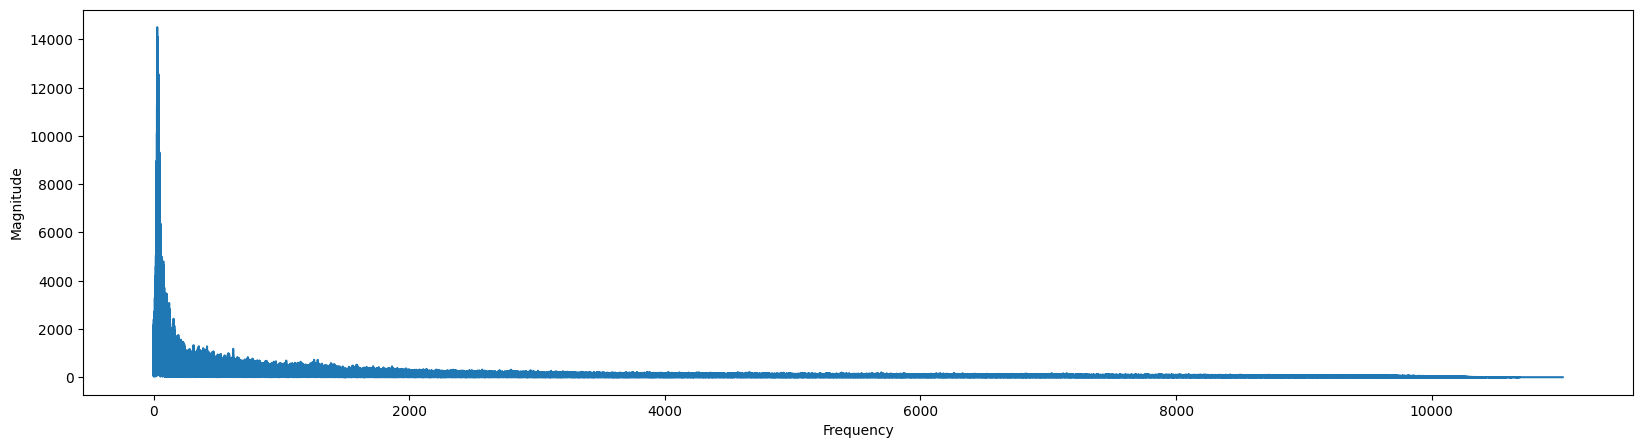

In [19]:
for i in range(1):
    fourier_transform(i)

> 음성이 어느 주파수의 어느 정도 magnitude를 가진 주기함수로 구성되어있다는건 알지만, 시간정보가 손실되어서 음성합성 & 인식에 이용하기에는 적절치 않음

> sfft 수행 (Short Time Fourier Transform) -> 음성 데이터를 시간 단위로 짧게 쪼개서 FFT  
    -> 각 시간당 주파수를 볼수있고 주파수가 얼마나 영향을 끼치는지 dB 단위로 plot된 것을 볼 수 있다.  
    - 참고: https://judy-son.tistory.com/6

In [20]:
fft = 2048
hl = 512

stft = np.abs(librosa.stft(audio, n_fft = fft, hop_length = hl))

print(np.shape(stft))

(1025, 6605)


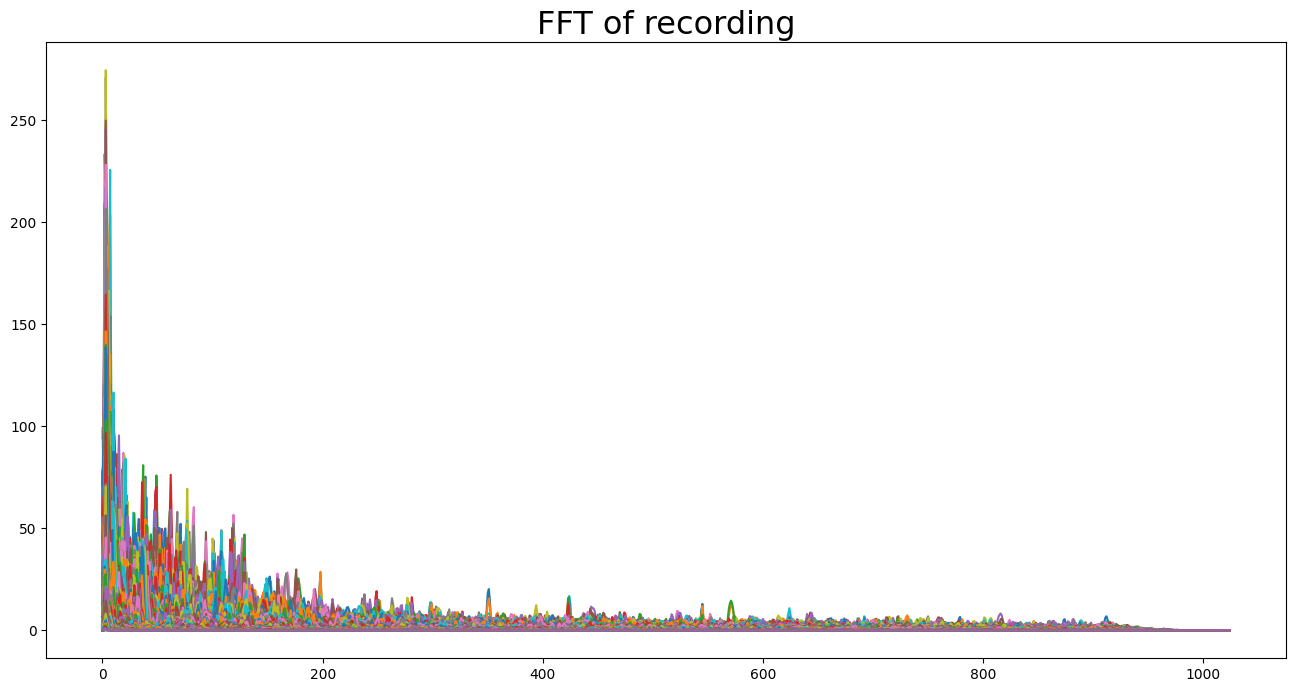

In [21]:
plt.figure(figsize = (16, 8))
plt.title("FFT of recording", fontsize = 23);
plt.plot(stft);

##### **멜 스펙트로그램**으로 변환

- **소리의 파형을 인간이 들을 수 있는 범위로 줄인 Mel scale로 다운 스케일한 이후 그 파형을 그림으로 그린 모양**
- mel scale: 주파수 척도를 인간의 청각 특성에 맞게 변환한 척도
- Mel은 사람의 달팽이관을 모티브로 따온 값
- 달팽이관은 주파수가 낮은 대역에서는 변화하는 주파수를 잘 감지하는데,
- 주파수가 높은 대역에서는 주파수 감지를 잘 하지 못함. (주파수 간격이 넓어짐)
- 이러한 원리를 이용해서 filter, scaling 해줄 수 있는데, 이때 이 기준을 Mel-Scale 이라고 함.
<br><br>

Argument (마찬가지로, Librosa 라이브러리 사용 )
1. **n_fft** : 한 번 fft를 해 줄 만큼의 sequence 길이
    - 여기서 n_fft는 window size라고도 부르는데, frame의 length를 결정하는 파라미터 입니다.
    - 사람의 목소리는 대부분 16000Hz 안에 포함이 되는데,
    - 일반적으로 자연어 처리에서는 음성을 25m의 크기를 기본으로 하고 있습니다.
    - 따라서 16000Hz인 음성에서는 25m의 음성의 크기를 가지고 있으면 n_fft는 16000 * 0.025 = 400 (sampling rate * frame_length = n_fft)가 됩니다.

2. **hop_length** : window 간의 거리
    - hop_length도 마찬가지로 window 간의 거리이므로 sampling rate * frame_stride 가 됩니다.

3. **win_length** : 윈도우 길이
    - 보통 win_length를 지정하지 않으면 n_fft가 됩니다.

In [24]:
# 여러 개의 오디오 처리
def Mel_s(num = 0, frame_length = 0.025, frame_stride = 0.010):
    # sample = os.listdir('./train')
    # temp = train[train.label == num].id
    # file_name = temp[temp.index[0]]
    
    # file = './train/' + file_name + '.wav'
    file = data_path + 'audio_furious.mp3'
    data,sample_rate = librosa.load(file, sr = 16000)
    
    input_nfft = int(round(sample_rate*frame_length))
    input_stride = int(round(sample_rate*frame_stride))
    
    S = librosa.feature.melspectrogram(y=data, n_mels=100, n_fft=input_nfft, hop_length=input_stride)
    
    print("Wav length: {}, Mel_S shape:{}".format(len(data)/sample_rate, np.shape(S)))
    
    S_dB  = librosa.power_to_db(S, ref=np.max)
    fig = plt.figure(figsize = (14,5))
    librosa.display.specshow(S_dB, 
                             sr=sample_rate, 
                             hop_length=input_stride,
                             x_axis='time',
                             y_axis='log')
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar(format='%+2.0f dB')
    # plt.title(f"Mel spectrogram of audio label {num}")
    plt.show()

Wav length: 153.39, Mel_S shape:(100, 15340)


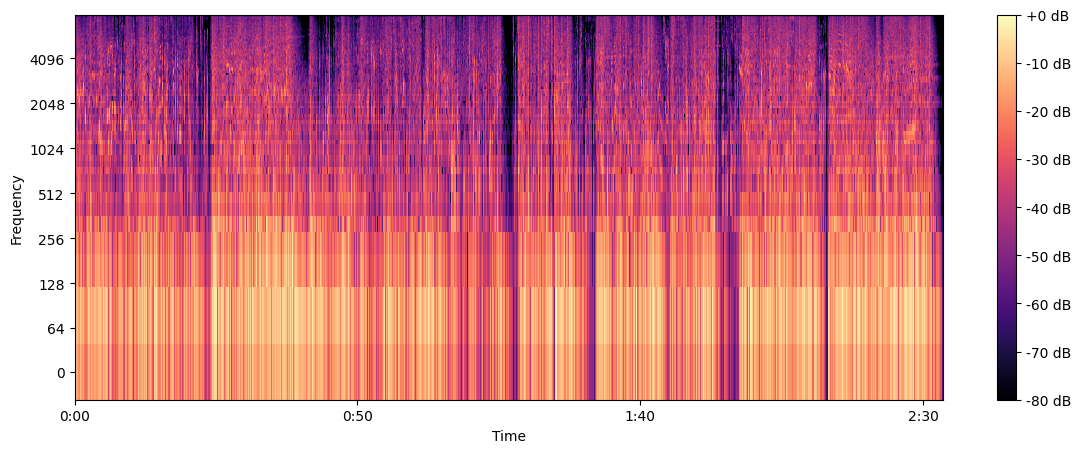

In [25]:
# 멜 스펙트로그램으로 변환
for i in range(1):
    Mel_s(i)

In [27]:
# !git clone https://github.com/f90/Wave-U-Net.git

Cloning into 'Wave-U-Net'...
